# Preprocesamiento de la Data y Modelado de Churn (Proyecto Final - "DesafÍA la IA" Predicción de rotación de clientes (Churn) en una empresa de Telecomunicaciones)

**Descripción:** En este notebook está contemplada la etapa donde se preparan los datos para entrenamiento, se construyen modelos de predicción y se evalúa su desempeñode.  
**Autor:** Erik González Molina


In [69]:
# Importamos las librerías necesarias para preprocesamiento y modelado
import pandas as pd
import numpy as np
import joblib
import os
# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
# Preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
# Modelos base
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# Métricas de evaluación
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

## 1. Carga de la Data limpia  
Se carga la Data limpia (telco_customer_churn.csv). La variable objetivo Churn será transformada a formato binario (Yes → 1, No → 0) para su uso en modelos de clasificación.  
### Carga de Data  


In [70]:
# Cargamos los datos en mi variable data
data = pd.read_csv('../Data/telco_customer_churn.csv')
# Visualizamos las primeras 5 filas.
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Convertimos la Data

In [71]:
# Convertimos la variable objetivo 'Churn' a formato numérico (Yes → 1, No → 0)
data['Churn'] = data['Churn'].map({'Yes': 1, 'No': 0})
# Confirmamos que la conversión se haya hecho correctamente
print("\nDistribución de la variable 'Churn' después de la conversión:")
print(data['Churn'].value_counts())


Distribución de la variable 'Churn' después de la conversión:
Churn
0    5174
1    1869
Name: count, dtype: int64


## 2. Identificación y Separación de Variables  
Separamos las variables en **numéricas** y **categóricas** para aplicar el preprocesamiento adecuado a cada tipo:

- Las variables categóricas se codificarán (LabelEncoder o One-Hot Encoding).
- Las numéricas pueden ser escaladas posteriormente si el modelo lo requiere.

In [72]:
# Visualizamos tipos de datos únicos por columna
print("Tipos de datos en el dataset:\n")
print(data.dtypes)
# Identificamos variables categóricas (tipo 'object') y algunas binarias (como SeniorCitizen que es int, pero categórica)
categorical_cols = data.select_dtypes(include='object').columns.tolist()
categorical_cols += ['SeniorCitizen']  # Aunque es numérica, es binaria → tratada como categórica
# Excluimos la variable objetivo ('Churn') de las predictoras
categorical_cols = [col for col in categorical_cols if col != 'Churn']
# Variables numéricas (reales, no categóricas)
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols.remove('SeniorCitizen')  # Ya la tratamos como categórica
numeric_cols.remove('Churn')          # Es la variable objetivo
# Mostramos el resultado
print("\nVariables categóricas:")
print(categorical_cols)
print("Variables numéricas:")
print(numeric_cols)


Tipos de datos en el dataset:

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                 int64
dtype: object

Variables categóricas:
['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'SeniorCitizen']
Variables numéricas:
['tenure', 'MonthlyCharges']


## 3. Limpieza de columnas no predictivas y corrección de tipos
- Se elimina la columna customerID, ya que es solo un identificador único y no aporta valor predictivo.
- Se convierte TotalCharges de texto a numérico.
- Se actualiza la lista de variables categóricas para excluir columnas no relevantes.

In [73]:
# Eliminamos la columna identificador (customerID)
if 'customerID' in data.columns:
    data.drop(columns='customerID', inplace=True)
    print("Columna 'customerID' eliminada.")
# Convertimos 'TotalCharges' a numérico (por si sigue como texto)
if data['TotalCharges'].dtype == 'object':
    data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
    nulos_totalcharges = data['TotalCharges'].isnull().sum()
    print(f"'TotalCharges' convertida a float. Valores nulos detectados: {nulos_totalcharges}")
    # Eliminamos filas con valores faltantes en TotalCharges (si existen)
    if nulos_totalcharges > 0:
        data = data.dropna(subset=['TotalCharges'])
        print("Filas con 'TotalCharges' nulo eliminadas.")
# Confirmamos tipo actualizado
print(f"\nTipo actual de 'TotalCharges': {data['TotalCharges'].dtype}")
# Actualizamos lista de variables categóricas
categorical_cols = data.select_dtypes(include='object').columns.tolist()
categorical_cols += ['SeniorCitizen']  # Es binaria, la tratamos como categórica
categorical_cols = [col for col in categorical_cols if col != 'Churn']  # Excluimos la variable objetivo
# Variables numéricas (ya actualizadas)
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols.remove('SeniorCitizen')
numeric_cols.remove('Churn')
# Resumen actualizado
print("\nVariables categóricas actualizadas:")
print(categorical_cols)
print("\nVariables numéricas actualizadas:")
print(numeric_cols)

Columna 'customerID' eliminada.
'TotalCharges' convertida a float. Valores nulos detectados: 11
Filas con 'TotalCharges' nulo eliminadas.

Tipo actual de 'TotalCharges': float64

Variables categóricas actualizadas:
['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen']

Variables numéricas actualizadas:
['tenure', 'MonthlyCharges', 'TotalCharges']


## 4. Codificación de Variables Categóricas  
En este paso se codifican todas las variables categóricas para que puedan ser utilizadas por modelos de machine learning:

1. Variables **binarias** (como Yes/No, Male/Female, SeniorCitizen) se codifican usando LabelEncoder.
2. Variables **multiclase** (como Contract, PaymentMethod) se codifican mediante **One-Hot Encoding** usando pd.get_dummies().  

Este enfoque permite mantener interpretabilidad y compatibilidad con distintos algoritmos.

In [74]:
from sklearn.preprocessing import LabelEncoder
# Inicializamos codificador para variables binarias
le = LabelEncoder()
# Creamos una copia del dataframe para codificación
data_encoded = data.copy()
# Codificamos variables binarias (2 categorías)
binary_cols = [col for col in categorical_cols if data[col].nunique() == 2]
print(" Codificando variables binarias con LabelEncoder:")
for col in binary_cols:
    data_encoded[col] = le.fit_transform(data_encoded[col])
    print(f" - {col}: {data[col].unique().tolist()} → {le.classes_.tolist()}")
# El resto se codifica con One-Hot Encoding
multiclass_cols = [col for col in categorical_cols if col not in binary_cols]
# One-hot encoding → evita colinealidad dejando drop_first=True
data_encoded = pd.get_dummies(data_encoded, columns=multiclass_cols, drop_first=True)
# Resultado final
print(f"\n Dataset codificado con {data_encoded.shape[1]} columnas.")
print(" Variables binarias codificadas:", binary_cols)
print(" Variables multiclase codificadas con one-hot:", multiclass_cols)

 Codificando variables binarias con LabelEncoder:
 - gender: ['Female', 'Male'] → ['Female', 'Male']
 - Partner: ['Yes', 'No'] → ['No', 'Yes']
 - Dependents: ['No', 'Yes'] → ['No', 'Yes']
 - PhoneService: ['No', 'Yes'] → ['No', 'Yes']
 - PaperlessBilling: ['Yes', 'No'] → ['No', 'Yes']
 - SeniorCitizen: [0, 1] → [0, 1]

 Dataset codificado con 31 columnas.
 Variables binarias codificadas: ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'SeniorCitizen']
 Variables multiclase codificadas con one-hot: ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']


## 5. División de Variables y Separación del Dataset  

Se separa la variable objetivo (y = Churn) del resto de variables predictoras (X).
Luego se divide el dataset en 3 subconjuntos:

- 70% para entrenamiento (X_train, y_train)
- 15% para validación (X_val, y_val)
- 15% para prueba final (X_test, y_test)

Esto permite evaluar el modelo durante el desarrollo (validación) y al final (test) de forma independiente.

In [75]:
from sklearn.model_selection import train_test_split
#  Variable objetivo
y = data_encoded['Churn']
#  Variables predictoras (todas las demás)
X = data_encoded.drop(columns='Churn')
#  División inicial: entrenamiento + resto (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
#  División del 30% restante en validación y test (50/50 del 30% → 15% y 15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)
#  Verificación de tamaños
print(" Tamaños de los subconjuntos:")
print(f"- X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"- X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"- X_test:  {X_test.shape}, y_test:  {y_test.shape}")
#  Verificación de balance
print("\n Distribución de clases en los subconjuntos:")
print("Entrenamiento:\n", y_train.value_counts(normalize=True).round(2))
print("Validación:\n", y_val.value_counts(normalize=True).round(2))
print("Test:\n", y_test.value_counts(normalize=True).round(2))

 Tamaños de los subconjuntos:
- X_train: (4922, 30), y_train: (4922,)
- X_val:   (1055, 30), y_val:   (1055,)
- X_test:  (1055, 30), y_test:  (1055,)

 Distribución de clases en los subconjuntos:
Entrenamiento:
 Churn
0    0.73
1    0.27
Name: proportion, dtype: float64
Validación:
 Churn
0    0.73
1    0.27
Name: proportion, dtype: float64
Test:
 Churn
0    0.73
1    0.27
Name: proportion, dtype: float64


## 6. Modelo Base: Regresión Lógica  
Entrenamos un primer modelo con LogisticRegression para tener un punto de comparación inicial.
Se evalúa su desempeño con las siguientes métricas:

- Matriz de confusión
- Accuracy, Precision, Recall, F1-score
- Curva AUC-ROC

 Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       774
           1       0.70      0.60      0.65       281

    accuracy                           0.82      1055
   macro avg       0.78      0.75      0.77      1055
weighted avg       0.82      0.82      0.82      1055

 Matriz de confusión:
[[700  74]
 [111 170]]
 AUC-ROC: 0.8532


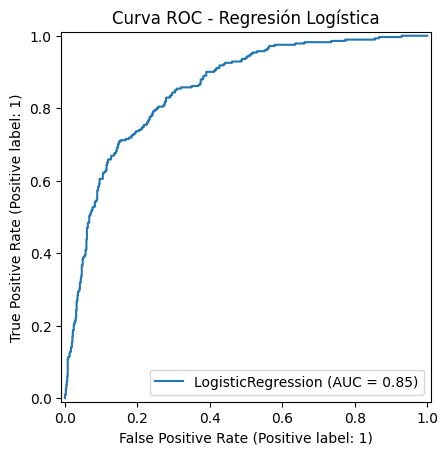

In [76]:
# Asignamos carpeta para guardar gráficos
output_folder = "../Visuals/preprocesamiento_y_modelado"

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
# Instanciamos y entrenamos el modelo
log_model = LogisticRegression(max_iter=3000, random_state=42)
log_model.fit(X_train, y_train)
# Predicción en el conjunto de validación
y_pred = log_model.predict(X_val)
y_prob = log_model.predict_proba(X_val)[:, 1]  # Probabilidad para curva ROC
# Reporte de métricas
print(" Reporte de clasificación:")
print(classification_report(y_val, y_pred))
#  Matriz de confusión
print(" Matriz de confusión:")
print(confusion_matrix(y_val, y_pred))
#  AUC-ROC
auc_score = roc_auc_score(y_val, y_prob)
print(f" AUC-ROC: {auc_score:.4f}")
#  Curva ROC
RocCurveDisplay.from_estimator(log_model, X_val, y_val)
plt.title("Curva ROC - Regresión Logística")
plt.savefig(os.path.join(output_folder, 'Curva_ROC_Regresión_Logística'), dpi=300)
plt.show()

## 7. Escalado de Variables Numéricas  
Para mejorar la convergencia y rendimiento de modelos sensibles a escalas (como la regresión logística),
se escalan únicamente las variables numéricas (tenure, MonthlyCharges, TotalCharges) utilizando StandardScaler.

El escalado se realiza **solo con los datos de entrenamiento**, para evitar fuga de información (data leakage).

In [77]:
from sklearn.preprocessing import StandardScaler

#  Creamos copias de los conjuntos para mantener los originales
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()
#  Columnas a escalar (ya las tenemos definidas como numeric_cols)
cols_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges']
#  Inicializamos el scaler y lo ajustamos solo con los datos de entrenamiento
scaler = StandardScaler()
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
#  Aplicamos el mismo escalado a validación y test
X_val_scaled[cols_to_scale] = scaler.transform(X_val[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])
#  Confirmamos estadísticas de escalado
print(" Promedio de variables escaladas (entrenamiento):")
print(X_train_scaled[cols_to_scale].mean().round(2))
print("\n Desviación estándar:")
print(X_train_scaled[cols_to_scale].std().round(2))

 Promedio de variables escaladas (entrenamiento):
tenure            0.0
MonthlyCharges    0.0
TotalCharges      0.0
dtype: float64

 Desviación estándar:
tenure            1.0
MonthlyCharges    1.0
TotalCharges      1.0
dtype: float64


## 8. Reentrenamiento de Regresión Logística (con datos escalados)  
Ahora se entrena nuevamente el modelo de regresión logística, esta vez utilizando las variables numéricas escaladas para asegurar una mejor convergencia y rendimiento.

 Reporte de clasificación (con escalado):
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       774
           1       0.69      0.60      0.65       281

    accuracy                           0.82      1055
   macro avg       0.78      0.75      0.76      1055
weighted avg       0.82      0.82      0.82      1055

 Matriz de confusión:
[[699  75]
 [111 170]]
 AUC-ROC: 0.8533


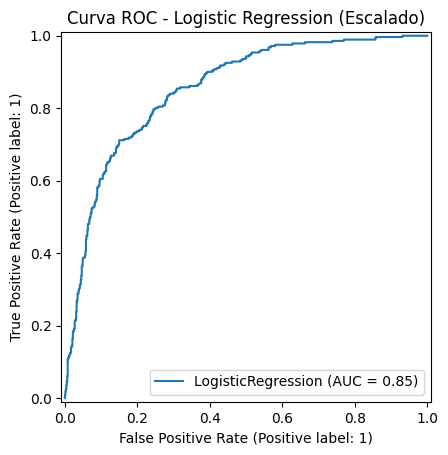

In [78]:
# Asignamos carpeta para guardar gráficos
output_folder = "../Visuals/preprocesamiento_y_modelado"
#  Modelo con datos escalados
log_model_scaled = LogisticRegression(max_iter=1000, random_state=42)
log_model_scaled.fit(X_train_scaled, y_train)
#  Predicciones
y_pred_scaled = log_model_scaled.predict(X_val_scaled)
y_prob_scaled = log_model_scaled.predict_proba(X_val_scaled)[:, 1]
#  Reporte actualizado
print(" Reporte de clasificación (con escalado):")
print(classification_report(y_val, y_pred_scaled))
print(" Matriz de confusión:")
print(confusion_matrix(y_val, y_pred_scaled))
print(f" AUC-ROC: {roc_auc_score(y_val, y_prob_scaled):.4f}")
# Curva ROC
RocCurveDisplay.from_estimator(log_model_scaled, X_val_scaled, y_val)
plt.title("Curva ROC - Logistic Regression (Escalado)")
plt.savefig(os.path.join(output_folder, 'Curva_ROC_Logistic_Regression_Escalado'), dpi=300)
plt.show()

## 9. Modelo Base: Árbol de Decisión  
Entrenamos un árbol de decisión utilizando las variables originales (no escaladas).
Los árboles no requieren escalado ni codificación especial, y permiten entender mejor las decisiones del modelo.

Se evaluará su desempeño con:

- Matriz de confusión
- Accuracy, Precision, Recall, F1-score
- AUC-ROC

 Reporte de clasificación (Árbol de Decisión):
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       774
           1       0.49      0.51      0.50       281

    accuracy                           0.73      1055
   macro avg       0.65      0.66      0.66      1055
weighted avg       0.73      0.73      0.73      1055

 Matriz de confusión:
[[623 151]
 [137 144]]
 AUC-ROC: 0.6601


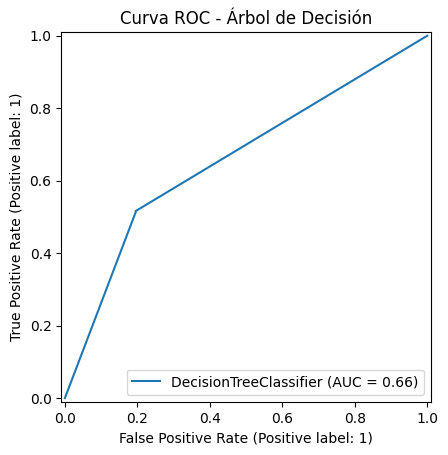

In [79]:
# Asignamos carpeta para guardar gráficos
output_folder = "../Visuals/preprocesamiento_y_modelado"

from sklearn.tree import DecisionTreeClassifier
#  Instanciamos el modelo (sin profundidad limitada para primera prueba)
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)
#  Predicciones
y_pred_tree = tree_model.predict(X_val)
y_prob_tree = tree_model.predict_proba(X_val)[:, 1]
#  Reporte
print(" Reporte de clasificación (Árbol de Decisión):")
print(classification_report(y_val, y_pred_tree))
print(" Matriz de confusión:")
print(confusion_matrix(y_val, y_pred_tree))
print(f" AUC-ROC: {roc_auc_score(y_val, y_prob_tree):.4f}")
#  Curva ROC
RocCurveDisplay.from_estimator(tree_model, X_val, y_val)
plt.title("Curva ROC - Árbol de Decisión")
plt.savefig(os.path.join(output_folder, 'Curva_ROC_Arbol_de_Decisión'), dpi=300)
plt.show()

## 10. Modelo Base: Random Forest  
Random Forest combina múltiples árboles de decisión entrenados sobre diferentes subconjuntos de datos y características,
para mejorar la capacidad de generalización y evitar el sobreajuste. No requiere escalado de variables.

Se evalúa con:

- Matriz de confusión
- Reporte de clasificación
- Curva AUC-ROC

 Reporte de clasificación (Random Forest):
              precision    recall  f1-score   support

           0       0.83      0.90      0.87       774
           1       0.65      0.51      0.57       281

    accuracy                           0.80      1055
   macro avg       0.74      0.70      0.72      1055
weighted avg       0.78      0.80      0.79      1055

 Matriz de confusión:
[[697  77]
 [139 142]]
 AUC-ROC: 0.8289


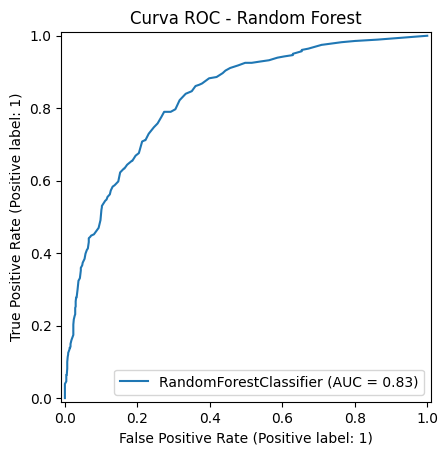

In [80]:
# Asignamos carpeta para guardar gráficos
output_folder = "../Visuals/preprocesamiento_y_modelado"

from sklearn.ensemble import RandomForestClassifier
#  Instanciamos y entrenamos el modelo
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
#  Predicciones en validación
y_pred_rf = rf_model.predict(X_val)
y_prob_rf = rf_model.predict_proba(X_val)[:, 1]
#  Reporte
print(" Reporte de clasificación (Random Forest):")
print(classification_report(y_val, y_pred_rf))
print(" Matriz de confusión:")
print(confusion_matrix(y_val, y_pred_rf))
print(f" AUC-ROC: {roc_auc_score(y_val, y_prob_rf):.4f}")
#  Curva ROC
RocCurveDisplay.from_estimator(rf_model, X_val, y_val)
plt.title("Curva ROC - Random Forest")
plt.savefig(os.path.join(output_folder, 'Curva_ROC_Random_Forest'), dpi=300)
plt.show()

## 11. Comparación de Modelos – Logistic vs Árbol vs Random Forest  
En este bloque se presentan las métricas clave de los modelos entrenados:

- Accuracy: porcentaje de predicciones correctas
- F1-score (Churn = 1): balance entre precisión y recall para detectar churn
- AUC-ROC: capacidad del modelo para separar churners de no churners
Estas métricas permiten visualizar el rendimiento general y facilitar la elección del mejor modelo para el proyecto.

 Tabla comparativa de métricas por modelo:

                Modelo  Accuracy  F1_Churn  AUC_ROC
0  Logistic Regression      0.82      0.65   0.8533
1    Árbol de Decisión      0.73      0.50   0.6601
2        Random Forest      0.80      0.57   0.8289


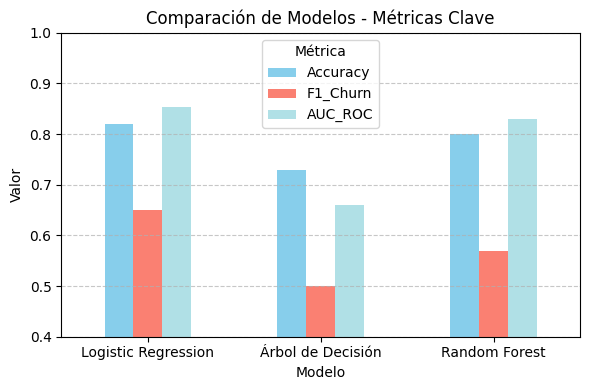

In [81]:
# Asignamos carpeta para guardar gráficos
output_folder = "../Visuals/preprocesamiento_y_modelado"

#  Métricas recogidas manualmente de los resultados anteriores
metricas_modelos = {
    "Modelo": ["Logistic Regression", "Árbol de Decisión", "Random Forest"],
    "Accuracy": [0.82, 0.73, 0.80],
    "F1_Churn": [0.65, 0.50, 0.57],
    "AUC_ROC": [0.8533, 0.6601, 0.8289]
}
#  Creamos un DataFrame con las métricas
data_metricas = pd.DataFrame(metricas_modelos)
print(" Tabla comparativa de métricas por modelo:\n")
print(data_metricas)
#  Gráfico comparativo
data_metricas.set_index("Modelo").plot(kind="bar", figsize=(6,4), rot=0, color=['skyblue', 'salmon', 'powderblue'])
plt.title("Comparación de Modelos - Métricas Clave")
plt.ylabel("Valor")
plt.ylim(0.4, 1.0)
plt.legend(title="Métrica")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'Diagrama_ Métricas_Claves'), dpi=300)
plt.show()

## 12. Importancia de Variables – Random Forest  
El modelo Random Forest permite analizar qué variables fueron más relevantes para predecir el churn, a través del atributo feature_importances_.

Esta visualización ayuda a interpretar el comportamiento del modelo y descubrir los factores clave que influyen en la cancelación de clientes.

 Top 15 variables más importantes según Random Forest:

TotalCharges                      0.197248
tenure                            0.168587
MonthlyCharges                    0.162756
PaymentMethod_Electronic check    0.038119
InternetService_Fiber optic       0.036196
gender                            0.029571
OnlineSecurity_Yes                0.027926
Contract_Two year                 0.026755
PaperlessBilling                  0.026372
TechSupport_Yes                   0.024852
Partner                           0.023134
OnlineBackup_Yes                  0.022314
Contract_One year                 0.020834
SeniorCitizen                     0.020788
MultipleLines_Yes                 0.020768
dtype: float64


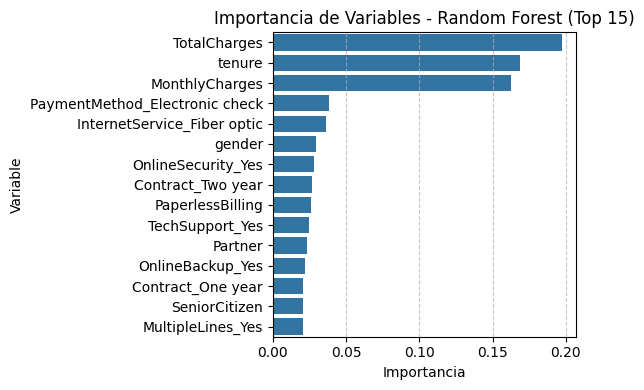

In [82]:
# Asignamos carpeta para guardar gráficos
output_folder = "../Visuals/preprocesamiento_y_modelado"

#  Obtenemos la importancia de cada variable
importancia = pd.Series(rf_model.feature_importances_, index=X_train.columns)
#  Ordenamos de mayor a menor importancia
importancia = importancia.sort_values(ascending=False)
#  Mostramos las 15 variables más relevantes
print(" Top 15 variables más importantes según Random Forest:\n")
print(importancia.head(15))
#  Visualización
plt.figure(figsize=(6, 4))
sns.barplot(x=importancia.head(15), y=importancia.head(15).index)
plt.title("Importancia de Variables - Random Forest (Top 15)")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'Diagrama_ Importancia_de_Variables'), dpi=300)
plt.show()

## 13. Modelo Avanzado: XGBoost  
XGBoost (Extreme Gradient Boosting) es un algoritmo basado en árboles de decisión que
utiliza el principio de boosting para mejorar el rendimiento del modelo.
Es robusto, rápido y muy efectivo para tareas de clasificación binaria como el churn.

Se evaluará con las mismas métricas: accuracy, F1-score, AUC-ROC y matriz de confusión.

 Reporte de clasificación (XGBoost):
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       774
           1       0.63      0.52      0.57       281

    accuracy                           0.79      1055
   macro avg       0.73      0.70      0.72      1055
weighted avg       0.78      0.79      0.78      1055

 Matriz de confusión:
[[688  86]
 [135 146]]
 AUC-ROC: 0.8274


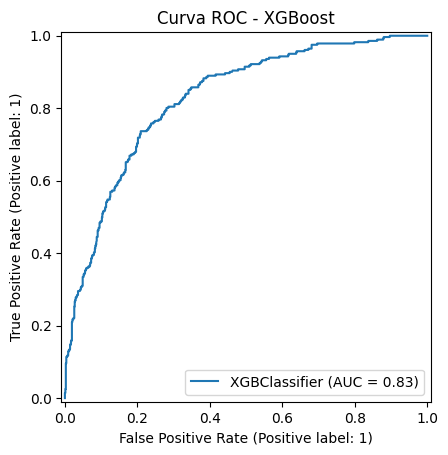

In [83]:
# Asignamos carpeta para guardar gráficos
output_folder = "../Visuals/preprocesamiento_y_modelado"
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
# Instanciamos el modelo con hiperparámetros por defecto
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
# Entrenamos con los datos codificados sin escalar (como Random Forest)
xgb_model.fit(X_train, y_train)
#  Predicción
y_pred_xgb = xgb_model.predict(X_val)
y_prob_xgb = xgb_model.predict_proba(X_val)[:, 1]
#  Reporte de métricas
print(" Reporte de clasificación (XGBoost):")
print(classification_report(y_val, y_pred_xgb))
print(" Matriz de confusión:")
print(confusion_matrix(y_val, y_pred_xgb))
print(f" AUC-ROC: {roc_auc_score(y_val, y_prob_xgb):.4f}")
#  Curva ROC
RocCurveDisplay.from_estimator(xgb_model, X_val, y_val)
plt.title("Curva ROC - XGBoost")
plt.savefig(os.path.join(output_folder, 'Curva_ROC_XGBoost'), dpi=300)
plt.show()

## 13. Resultados Finales del Modelado  
En este bloque se resumen y organizan los resultados de todos los modelos evaluados:

- Métricas clave: accuracy, F1-score, AUC-ROC
- Matriz de confusión: TP, TN, FP, FN
- Comparación en formato tabla
- Opción de guardar como CSV para incluir en reportes  

Este resumen servirá como base para tomar decisiones y redactar el informe final. 

In [84]:
#  Resultados recolectados manualmente de cada modelo (validación)
resultados_finales = {
    "Modelo": ["Logistic Regression", "Árbol de Decisión", "Random Forest", "XGBoost"],
    "Accuracy": [0.82, 0.73, 0.80, 0.79],
    "F1_Churn": [0.65, 0.50, 0.57, 0.57],
    "AUC_ROC": [0.8533, 0.6601, 0.8289, 0.8274],
    "TP": [168, 144, 142, 146],
    "FN": [113, 137, 139, 135],
    "FP": [76, 151, 77, 86],
    "TN": [698, 623, 697, 688]
}
#  Creamos el DataFrame resumen
data_resultados = pd.DataFrame(resultados_finales)
#  Mostramos el resumen completo
print(" Resultados comparativos finales:\n")
display(data_resultados)
#  Exportamos los resultados a CSV
data_resultados.to_csv("../Reports/resultados_modelos.csv", index=False)

 Resultados comparativos finales:



,Modelo,Accuracy,F1_Churn,AUC_ROC,TP,FN,FP,TN
0,Logistic Regression,0.82,0.65,0.8533,168,113,76,698
1,Árbol de Decisión,0.73,0.50,0.6601,144,137,151,623
2,Random Forest,0.80,0.57,0.8289,142,139,77,697
3,XGBoost,0.79,0.57,0.8274,146,135,86,688


## 14. Conclusiones Finales del Modelado  
Tras evaluar cuatro modelos de clasificación para predecir la cancelación de clientes (churn), se concluye lo siguiente:

- **Logistic Regression (con escalado)** fue el modelo con mejor desempeño global, obteniendo:

- Accuracy: **0.82**
- F1-score (Churn): **0.65**
- AUC-ROC: **0.8533**
- También tuvo la mejor capacidad para distinguir entre churners y no churners.

- **Random Forest y XGBoost** presentaron resultados muy similares, ambos robustos y balanceados, con F1 = 0.57 y AUC-ROC superiores a 0.82. Son buenas opciones cuando se busca interpretabilidad o estabilidad en producción.

- **Árbol de Decisión simple** mostró el peor rendimiento, afectado por sobreajuste y baja generalización. Se recomienda solo con fine-tuning o para visualización simple.

- **Recomendación**: Utilizar el modelo de Logistic Regression (escalado) como base para hacer predicciones reales, por su buen rendimiento, estabilidad y facilidad de interpretación.

Este análisis permitirá a la empresa anticipar qué clientes tienen mayor probabilidad de abandonar el servicio, y tomar medidas proactivas para reducir el churn.  

In [85]:
#  Guardar el modelo y el scaler
joblib.dump(log_model_scaled, "../Models/logistic_regression_model.pkl")
joblib.dump(scaler, "../Models/standard_scaler.pkl")
joblib.dump(tree_model, "../Models/tree_model.pkl")
joblib.dump(rf_model, "../Models/rf_model.pkl")
joblib.dump(xgb_model, "../Models/xgb_model.pkl")
print(" Modelo y scaler guardados correctamente.")

 Modelo y scaler guardados correctamente.
